In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import yaml
from pathlib import Path
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import geopandas as gpd
from shapely.geometry import Point
import cartopy.feature as cfeature
import cartopy.crs as ccrs

from lisfloodreservoirs import read_attributes

## Configuration

In [7]:
data_dir = Path('/eos/jeodpp/home/users/casadje/data/ResOpsMX')
version = 'v1.0'

In [3]:
model = 'hanazaki_2pars'

In [4]:
paths_runs = {
    'default': data_dir / 'results' / model / 'default',
    'storage': data_dir / 'results' / model / 'calibration' / 'storage',
    'outflow': data_dir / 'results' / model / 'calibration' / 'outflow',
    'bivariate': data_dir / 'results' / model / 'calibration' / 'bivariate'
}

In [5]:
par_range ={
    'alpha': (0.2, 0.99),
    'beta': (0.001, 0.999), 
    'gamma': (0.001, 0.999),
    'delta': (0.1, 0.5),
    'epsilon': (0.001, 0.999),
}

In [6]:
metric = 'KGE'

## Data

### Attributes

In [9]:
# load attributes
attributes = read_attributes(
    path=data_dir / version / 'attributes',
    reservoirs=pd.read_csv(data_dir / version / 'selection' / 'reservoirs.txt', header=None).squeeze().tolist()
)

In [10]:
# convert into geopandas
attributes = gpd.GeoDataFrame(
    attributes,
    geometry=[Point(xy) for xy in zip(attributes['LON'], attributes['LAT'])],
    crs='epsg:4326'
)

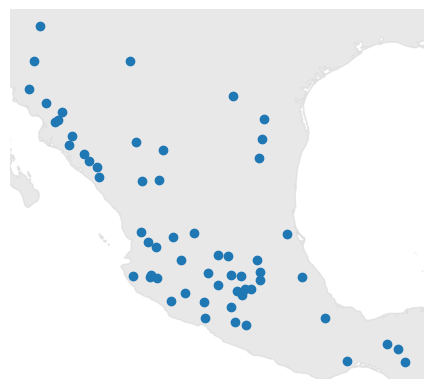

In [11]:
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'), alpha=.5, zorder=0)
attributes.plot(ax=ax)
ax.axis('off');

### Runs

In [14]:
results = []
for run, path in paths_runs.items():
    # optimal parameters
    parameters = pd.DataFrame(dtype=float)
    if run == 'default':
        for file in path.glob('*parameters.yml'):
            # reservoir ID
            ID = int(file.stem.split('_')[0])
            # extract alpha
            with open(file, 'r') as f:
                pars = yaml.safe_load(f)
            parameters.loc[ID, 'alpha'] = pars['Vf'] / pars['Vtot']
            if model.endswith('5pars'):
                parameters.loc[ID, 'beta'] = (pars['Vtot'] - pars['Ve']) / (pars['Vtot'] - pars['Vf'])
                parameters.loc[ID, 'gamma'] = pars['Vmin'] / pars['Vf'] 
                parameters.loc[ID, 'epsilon'] = pars['Qn'] / pars['Qf']
        parameters['delta'] = 0.30
    else:
        for file in path.glob('*samples.csv'):
            # reservoir ID
            ID = int(file.stem.split('_')[0])
            # extract best sample from the calibration
            samples = pd.read_csv(file)
            mask_cols = samples.columns.str.startswith('par')
            parvalues = samples.loc[[samples.like1.idxmin()], mask_cols]
            parvalues.index = [ID]
            parvalues.index.name = 'ID'
            parvalues.rename(columns={col: col[3:] for col in parvalues.columns if col.startswith('par')}, inplace=True)
            parameters = pd.concat((parameters, parvalues), axis=0)
    parameters.index.name = 'ID'
    
    # performance
    performance = pd.DataFrame(dtype=float)
    for file in path.glob('*performance.csv'):
        # reservoir ID
        ID = int(file.stem.split('_')[0])
        # extract best sample from the calibration
        perf = pd.read_csv(file, index_col='metric')
        perf = perf.loc[[metric], ['storage', 'outflow']]
        perf.index = [ID]
        perf.index.name = 'ID'
        perf.columns = [f'{metric}_{col}' for col in perf.columns]
        performance = pd.concat((performance, perf), axis=0)

    # concat all results
    results.append(xr.Dataset(pd.concat((parameters, performance), axis=1)).expand_dims(dim={'run': [run]}))

# merge in a single Dataset
results = xr.merge(results)
results = results.reindex(run=['default', 'storage', 'outflow', 'bivariate'])

### Analyse parameters

### Parameter values depending on the target variable

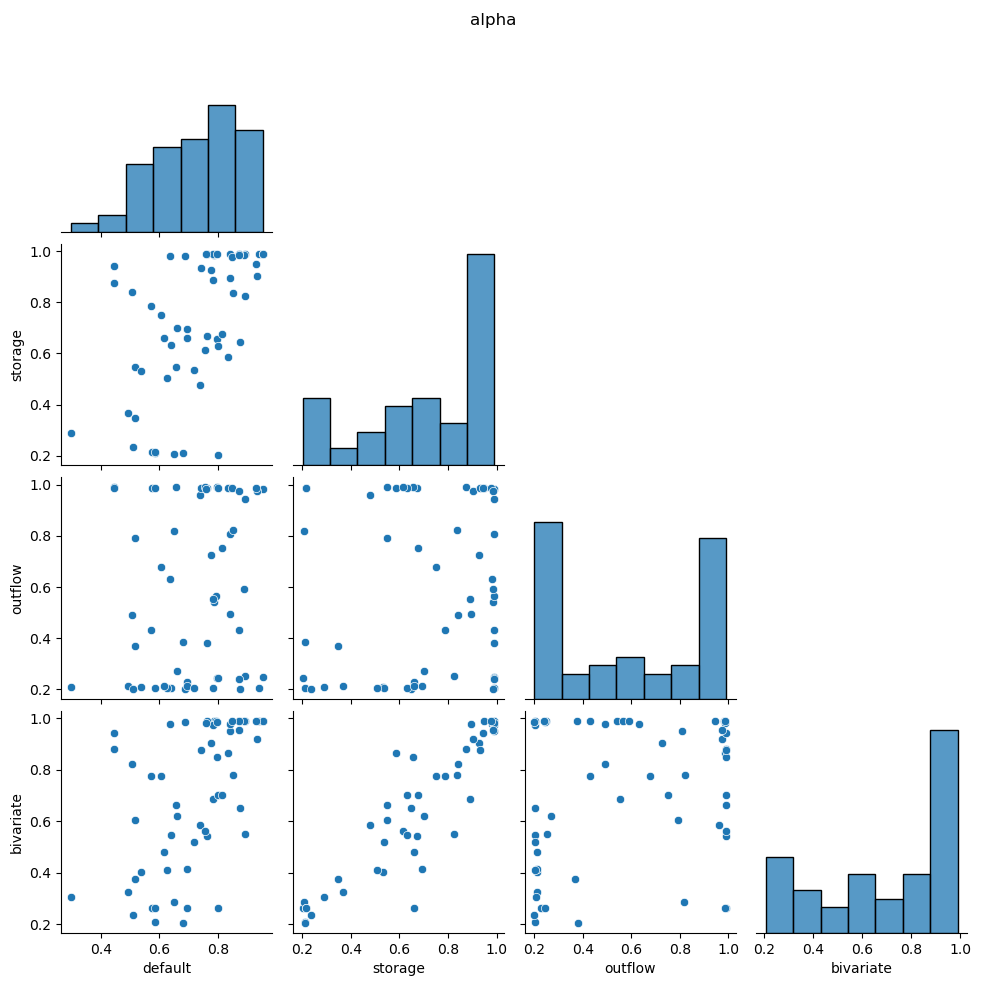

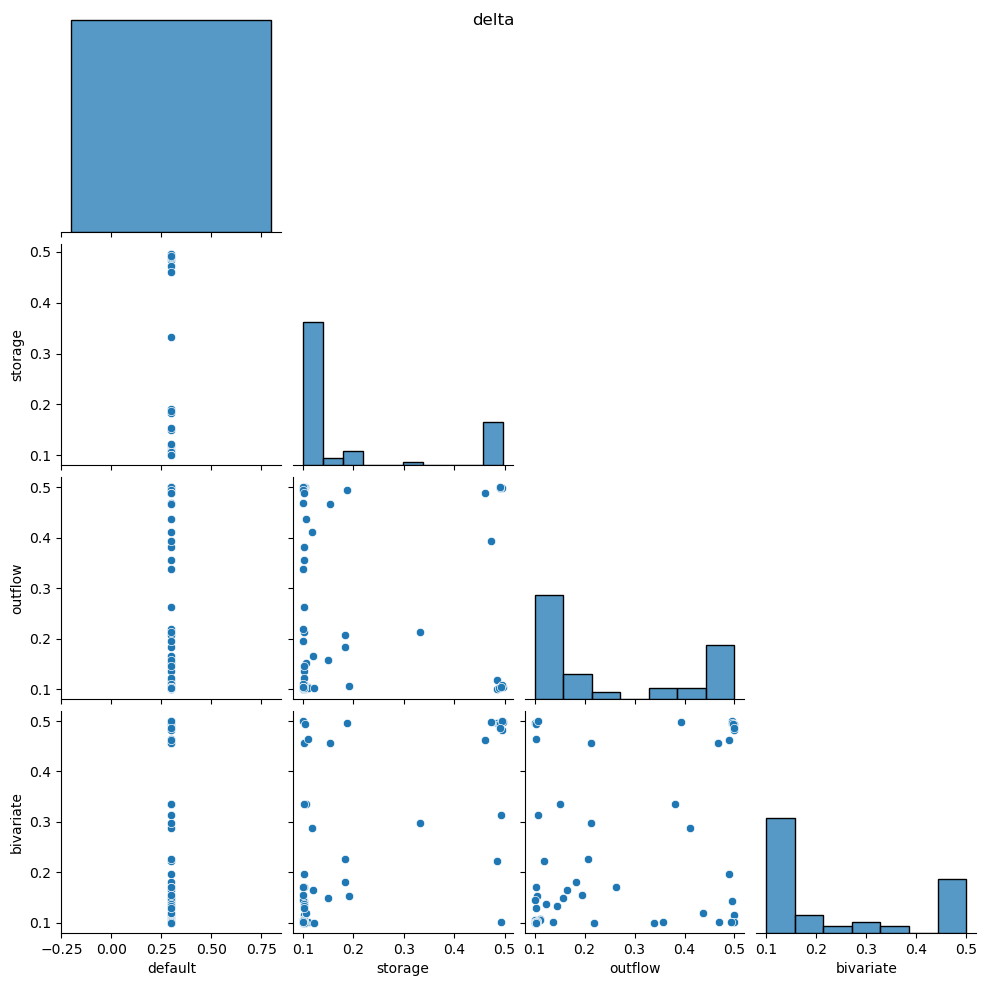

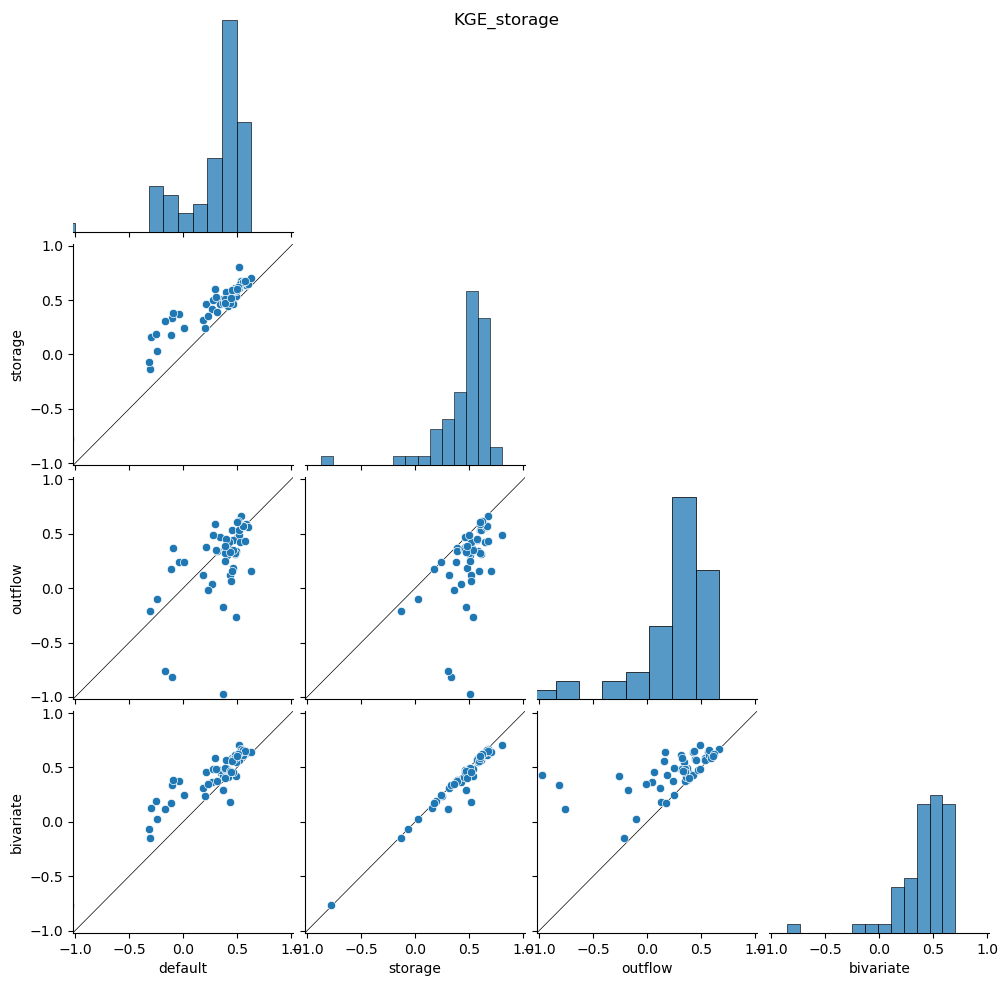

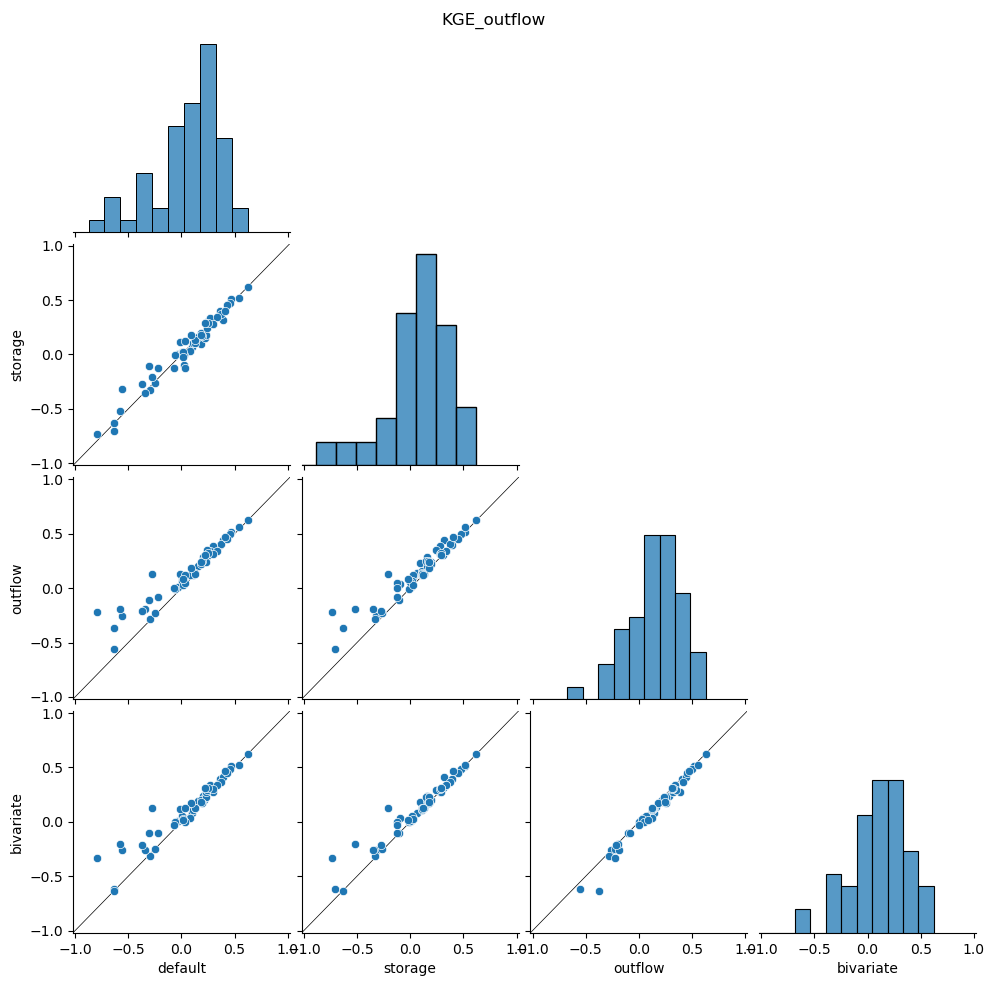

In [15]:
for par, da in results.items():
    pairplot = sns.pairplot(da.to_pandas().transpose(), corner=True)
    pairplot.fig.suptitle(par)
    if par.startswith('KGE'):
        axes = pairplot.axes
        for i in range(1, axes.shape[0]):
            for j in range(0, axes.shape[1]):
                if j >= i:
                    continue
                axes[i,j].plot((-1.02, 1.02), (-1.02, 1.02), lw=.5, c='k', zorder=0)
        pairplot.set(
            xlim=(-1.02, 1.02),
            ylim=(-1.02, 1.02),
        )

### Bivariate

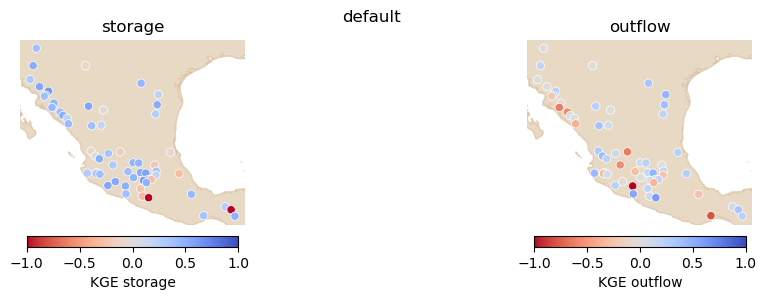

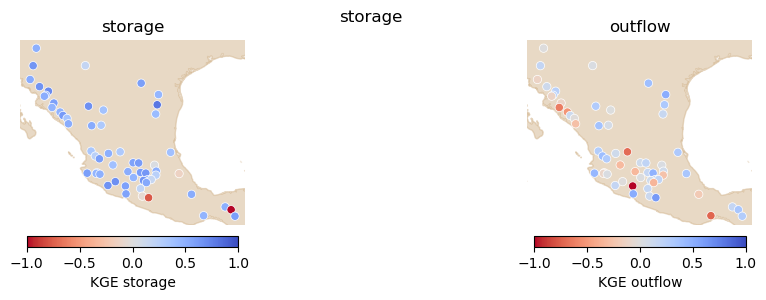

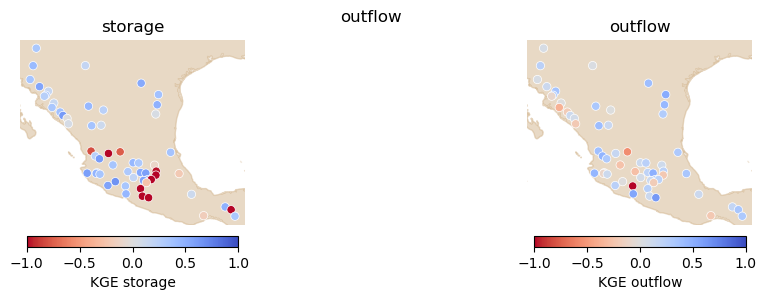

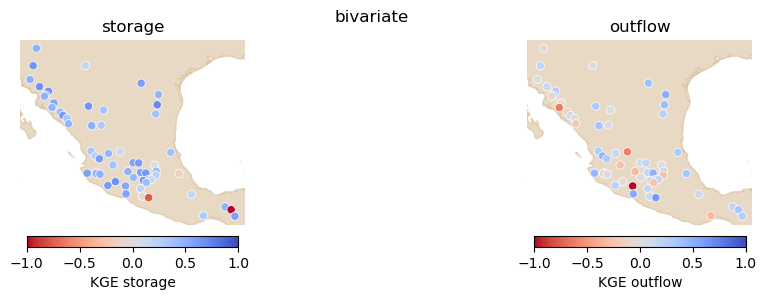

In [16]:
run = 'bivariate'
for run in results.run.data: 
    attributes.drop(['alpha', 'delta', 'KGE_storage', 'KGE_outflow'], axis=1, inplace=True, errors='ignore')

    df = results.sel(run=run).to_pandas().drop('run', axis=1)
    df.index.name = 'GRAND_ID'
    attributes = pd.concat((attributes, df), axis=1)

    fig, axes = plt.subplots(ncols=2, figsize=(12, 3), subplot_kw=dict(projection=ccrs.PlateCarree()))
    fig.suptitle(run)
    for ax, var in zip(axes, ['storage', 'outflow']):
        ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='tan'), alpha=.5, zorder=0)
        sct = ax.scatter(
            attributes.LON,
            attributes.LAT,
            c=attributes[f'KGE_{var}'],
            edgecolor='w',
            lw=.5,
            cmap='coolwarm_r',
            norm=mcolors.Normalize(vmin=-1, vmax=1)
        )
        ax.set_title(var)
        cbar = plt.colorbar(sct, orientation='horizontal', pad=.05, shrink=.5)#, ax=ax)
        cbar.set_label(f'KGE {var}')
        ax.axis('off');

In [17]:
thr = .25
mask_storage = attributes.KGE_storage >= thr
mask_outflow = attributes.KGE_outflow >= thr
mask_storage.sum(), mask_outflow.sum(), (mask_storage & mask_outflow).sum()

(47, 18, 14)

In [ ]:
sns.pairplot(results['delta'].to_pandas().transpose(), corner=True);

In [ ]:
parname = 'alpha'
df = pd.DataFrame({cal: df[parname] for cal, df in results.items()})
sns.pairplot(df, corner=True);

In [ ]:
parname = 'delta'
df = pd.DataFrame({cal: df[parname] for cal, df in results.items()})
sns.pairplot(df, corner=True);

In [ ]:
norm = mcolors.Normalize(vmin=-1, vmax=1)
fig, axes = plt.subplots(ncols=3, figsize=(10, 3), sharex=True, sharey=True)
for ax, (cal, df) in zip(axes, results.items()):
    sct = ax.scatter(df.alpha, df.delta, c=df.KGE_storage, cmap='coolwarm_r', norm=norm, s=8, alpha=.5)
    ax.set_title(cal)
plt.colorbar(sct);

In [ ]:
IDs = [int(file.stem.split('_')[0]) for file in path_default.glob('*_parameters.yml')]

In [ ]:
len(IDs)

In [ ]:
ID = 1006

In [ ]:
parameters = pd.DataFrame(dtype=float)
for run, path in paths_runs.items():
    file = list(path.glob(f'{ID}*parameters.yml'))[0]
    with open(file, 'r') as f:
        pars = pd.Series(yaml.safe_load(f), name=run)
        parameters = pd.concat((parameters, pars), axis=1)

In [ ]:
Q100 = parameters.loc['Qf', 'default'] / 0.3

In [ ]:
parameters.loc['Vf'] / parameters.loc['Vtot']

In [ ]:
parameters.loc['Qf'] / Q100

In [ ]:
V

In [ ]:
results['storage'].loc[ID]

In [ ]:
parameters

In [ ]:

with open(path_default / '1006_default_parameters.yml', 'r') as file:
    pars_def = pd.Series(yaml.safe_load(file), name='default')

with open(path_calibration / 'storage' / '1006_optimal_parameters.yml', 'r') as file:
    pars_storage = pd.Series(yaml.safe_load(file), name='storage')

with open(path_calibration / 'outflow' / '1006_optimal_parameters.yml', 'r') as file:
    pars_outflow = pd.Series(yaml.safe_load(file), name='outflow')

with open(path_calibration / 'bivariate' / '1006_optimal_parameters.yml', 'r') as file:
    pars_bivariate = pd.Series(yaml.safe_load(file), name='bivariate')

pd.concat((pars_def, pars_storage, pars_outflow, pars_bivariate), axis=1)

In [ ]:
pars.Vf / pars.Vtot

In [ ]:
Q100 = pars.Qf / .3
Q100

In [ ]:
pars

In [ ]:
thr = .5
for cal, df in results.items():
    print(cal)
    print('-' * len(cal))
    print((df.loc[:, df.columns.str.startswith('KGE')] > thr).sum() / df.shape[0])
    print()

In [ ]:
parameters['bivariate'].plot(type='scatter')